In [1]:
#@title Importing Packages

# Utility
import math as math
import numpy as np
import pandas as pd
import random as rdm
import scipy.io as io
import scipy.stats as stats
from google.colab import drive
import networkx as nx
import time

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.animation import FuncAnimation
from functools import partial

In [2]:
def findMode(sample):

    mode = 0
    count = 0
    for value in set(sample):
        countValue = sum([1 for num in sample if num == value])
        if countValue >= count:
            mode = value
            count = countValue
    
    return mode, count


In [3]:
#@title Function to plot pdf of distribution

def plotPDF(dist, mean, true):

    sample = dist.rvs(100000)
    plt.hist(sample, bins = int(len(sample)/100), alpha = 0.5)

    plt.scatter(mean, 0, s = 100, c = 'r', label = 'Mean')
    plt.scatter(true, 0, s = 100, c = 'g', label = 'True value')

    plt.legend()
    plt.show()



In [4]:
#@title Function to plot pmf of distribution

def plotPMF(dist, mean, true):

    sample = dist.rvs(100000)
    plt.hist(sample, alpha = 0.5)

    plt.scatter(mean, 0, s = 100, c = 'r', label = 'Mean')
    plt.scatter(true, 0, s = 100, c = 'g', label = 'True value')

    plt.legend()
    plt.show()


In [5]:
#@title function to plot walk of single parameter

def plotWalk(sample, true):

    plt.plot(range(len(sample)), sample)
    plt.plot([0, len(sample)], [true, true], label = 'True value')
    plt.legend()
    plt.show()

# Toy example for algae bloom

In [6]:
#@title Importing pmat

drive.mount('drive')

pmatRaw = pd.read_csv("https://drive.google.com/uc?export=download&id=18qzQ-2TRETglAGLSXRZekyQqK7QxXUff")
pmat = pmatRaw.copy()
pmat = pmat.set_index('Unnamed: 0')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [7]:
#@title Calculates Mit based upon parameters and Mi(t - 1)

def findMNew(M, t, A, Alpha, Beta, S, pmat):

  start = S
  growth = Alpha*(A*M)
  transport = Beta*np.dot(M, pmat)

  MNew = start + growth + transport

  return MNew

In [8]:
#@title generates sample with randomly generated parameter
def runSimulation(sites, length, pmat):

    Alpha = 2
    Beta = 0.8
    #Alpha = stats.gamma(1, 1).rvs()
    #Beta = stats.beta(1, 1).rvs()

    # Forcing N = 1 for MH purposes
    N = 1
    # N =  int(stats.geom.rvs(0.05))
    A = np.zeros((length, sites))
    S = np.zeros((length, sites))

    IArray = []
    TArray = []
    WArray = []
    SArray = []

    for n in range(N):
        i = stats.randint(0, sites - 1).rvs()
        #T = 30
        IArray.append(i)
        T = stats.randint(1, length - 1).rvs()
        TArray.append(T)
        W = int(stats.nbinom.rvs(6, 0.75)) + 1
        WArray.append(W)

        A[range(T, (min(T + W, length))), i] = 1
        Size = stats.gamma.rvs(1, 1)
        S[T, i] = Size
        SArray.append(Size)

    M = np.zeros(sites)
    MArray = np.zeros((sites, length))

    #print(f"Alpha: {Alpha}")
    #print(f"Beta: {Beta}")
    #print(f"T: {T}")
    #print(f"W: {W}")

    pDiag = [pmat.iloc[i, i] for i in range(sites)]

    for t in range(length):

        M = findMNew(M, t, A[t, :], Alpha, Beta, S[t, :], np.array(pmat.iloc[:sites, :sites]))
        MArray[:, t] = M

    return MArray, Alpha, Beta, N, IArray, TArray, WArray, SArray

In [9]:
#@title Runs simulation with given parameters

def getSample(sites, length, pmat, alpha, beta, N, I, T, W, Size):

    if (len(T) != N) or (len(W) != N) or (len(Size) != N) or (len(I) != N):
        print(N)
        print(len(T), len(W), len(Size))
        print("Error: Wrong length parameter vectors")
        return

    A = np.zeros((length, sites))
    S = np.zeros((length, sites))
    
    for n in range(N):
        A[range(T[n], (min(T[n] + W[n], length))), I[n]] = 1
        S[T[n], I[n]] = Size[n]

    M = np.zeros(sites)
    MArray = np.zeros((sites, length))
    #print(f"Alpha: {alpha}")
    #print(f"Beta: {beta}")
    #print(f"T: {T}")
    #print(f"W: {W}")

    for t in range(length):

        M = findMNew(M, t, A[t, :], alpha, beta, S[t, :], np.array(pmat.iloc[:sites, :sites]))
        MArray[:, t] = M

    return MArray

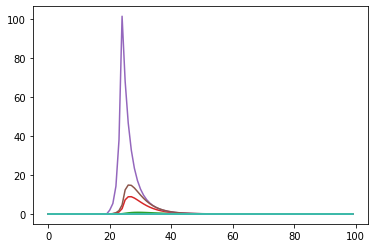

In [10]:
for i in range(10):
    plt.plot(getSample(10, 100, pmat, 2, 0.8, 1, [4], [20], [5], [2])[i])

In [11]:
#@title Function to convert mass into concentration

def convertConcentration(sites, length, M, V, delta):

    C = np.zeros((sites, length))
    for i in range(sites):
        C[i, :] = M[i, :]/V[i]
    if C.any() < 0:
        print("Negative Concentration")
    LogCArray = np.log(delta + C)

    return LogCArray

In [12]:
#@title Converting Concentration to Y

def convertY(C, tau):

    LogYArray = stats.norm(C, 1/np.sqrt(tau)).rvs()
    
    return LogYArray

Parameters known:
- t = length of time
- i = number of sites
- delta = dummy parameter to ensure log(delta + Mit/Vit) works
- V = (i x 1) vector of Volumes per site
---
Parameters to be estimated:
- Alpha = growth parameter
- Beta = decay parameter
- N = Number of events
- I = (n x 1) Vector of sites per event
- S = (i x t) Vector of Size Parameters
- A = (i x t) Vector of activation time
- T = (n x 1) vector of Start time parameters
- W = (n x 1) vector of Length of time parameters
- Epsilon = Error parameter

## MH sampler with unknown T

In [63]:
#@title MH sampler - Not even close

sites = 10
length = 100
delta = 0.0000000001
trueTau = stats.gamma(1, 1).rvs()
V = stats.nbinom(1, .1).rvs(sites) + 1
seed = stats.randint(1, 100).rvs()

sample, trueAlpha, trueBeta, trueN, trueI, trueT, trueW, trueS = runSimulation(sites, length, pmat)

CArray = convertConcentration(sites, length, sample, V, delta)
Y = convertY(CArray, trueTau)

# Prior parameters

  # Alpha
alphaA0 = 1
alphaB0 = 1
alphaPrior = stats.gamma(alphaA0, alphaB0)
alpha0 = alphaPrior.rvs()

  # Beta
betaA0 = 1
betaB0 = 1
betaPrior = stats.beta(betaA0, betaB0)
beta0 = betaPrior.rvs()

  # N
NA0 = 0.1
NPrior = stats.geom(NA0)
N0 = trueN
# N0 = int(NPrior.rvs())

  # I
IA0 = 0
IB0 = sites
IPrior = stats.randint(IA0, IB0)
I0 = IPrior.rvs(N0)

  # T
TA0 = 0
TB0 = length
TPrior = stats.randint(TA0, TB0)
T0 = TPrior.rvs(N0)

  # W
WA0 = 6
WB0 = 0.75
WPrior = stats.nbinom(WA0, WB0)
W0 = WPrior.rvs(N0)

  # S
SA0 = 1
SB0 = 1
SPrior = stats.gamma(SA0, SB0)
# S0 = [SPrior.rvs()]
S0 = SPrior.rvs(N0)

  # Tau
tauA0 = 1
tauB0 = 1
tauPrior = stats.gamma(tauA0, tauB0)
tau0 = tauPrior.rvs()

phi = [alpha0, beta0, N0, I0, T0, W0, S0, tau0]
S = 200000
PHI = dict.fromkeys(range(S))
PHI[0] = phi

alphaArray = np.zeros((S,))
betaArray = np.zeros((S,))
IArray = np.zeros((S, N0))
TArray = np.zeros((S, N0))
WArray = np.zeros((S, N0))
SArray = np.zeros((S, N0))
tauArray = np.zeros((S,))

alphaLikelihoodArray = np.zeros((S - 1,))
betaLikelihoodArray = np.zeros((S - 1,))
ILikelihoodArray = np.zeros((S - 1, N0))
TLikelihoodArray = np.zeros((S - 1, N0))
WLikelihoodArray = np.zeros((S - 1, N0))
SLikelihoodArray = np.zeros((S - 1, N0))
tauLikelihoodArray = np.zeros((S - 1,))

alphaLikelihoodArray = np.zeros((S,))
betaLikelihoodArray = np.zeros((S,))
ILikelihoodArray = np.zeros((S, N0))
TLikelihoodArray = np.zeros((S, N0))
WLikelihoodArray = np.zeros((S, N0))
SLikelihoodArray = np.zeros((S, N0))
tauLikelihoodArray = np.zeros((S,))

alphaRatioArray = np.zeros((S - 1,))
betaRatioArray = np.zeros((S - 1,))
IRatioArray = np.zeros((S - 1, N0))
TRatioArray = np.zeros((S - 1, N0))
WRatioArray = np.zeros((S - 1, N0))
SRatioArray = np.zeros((S - 1, N0))
tauRatioArray = np.zeros((S - 1,))

alphaArray[0] = alpha0
betaArray[0] = beta0
IArray[0, :] = I0
TArray[0, :] = T0
WArray[0, :] = W0
SArray[0, :] = S0
tauArray[0] = tau0

alphaAccept = 0
betaAccept = 0
IAccept = 0
TAccept = 0
WAccept = 0
SAccept = 0
tauAccept = 0

start = time.time()
for s in range(1, S):
  # Alpha
    # Grabbing candidate alpha
    qDistAlpha = stats.norm(phi[0], 1)
    alphaCandidate = qDistAlpha.rvs()
    qDistAlphaCandidate = stats.norm(alphaCandidate, 1)

    # Calculating mass and concentrations
    massSampleCandidate = getSample(sites, length, pmat, alphaCandidate, phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

    massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

    # Calculating probability
        # Prior
    priorCandidateP = alphaPrior.pdf(alphaCandidate)
    priorCurrentP = alphaPrior.pdf(phi[0])

        # Likelihood
    pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
    pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

    likelihoodCandidateP = pArrayCandidate.sum()
    likelihoodCurrentP = pArrayCurrent.sum()

    pCandidate = priorCandidateP*likelihoodCandidateP
    pCurrent = priorCurrentP*likelihoodCurrentP

        # Proposal
    qCandidate = qDistAlpha.pdf(alphaCandidate)
    qCurrent = qDistAlphaCandidate.pdf(phi[0])

    #print(pCandidate, pPrior)
    ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
    alphaRatioArray[s - 1] = ratio

    # Accept/Reject Alpha
    u = stats.uniform().rvs()
    if ratio >= u:
        print("Accepted Alpha: ", s)
        phi[0] = alphaCandidate
        alphaAccept += 1
        alphaLikelihoodArray[s - 1] = likelihoodCandidateP
    else:
        alphaLikelihoodArray[s - 1] = likelihoodCurrentP

    alphaArray[s] = phi[0]


  # Beta
    # Grabbing candidate beta
    qDistBeta = stats.beta(1, 1)
    betaCandidate = qDistBeta.rvs()
    qDistBetaCandidate = stats.beta(1, 1)

    # Calculating mass and concentrations
    massSampleCandidate = getSample(sites, length, pmat, phi[0], betaCandidate, phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

    massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

    # Calculating probability
        # Prior
    priorCandidateP = betaPrior.pdf(betaCandidate)
    priorCurrentP = betaPrior.pdf(phi[1])

        # Likelihood
    pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
    pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

    likelihoodCandidateP = pArrayCandidate.sum()
    likelihoodCurrentP = pArrayCurrent.sum()

    pCandidate = priorCandidateP*likelihoodCandidateP
    pCurrent = priorCurrentP*likelihoodCurrentP

        # Proposal
    qCandidate = qDistBeta.pdf(betaCandidate)
    qCurrent = qDistBetaCandidate.pdf(phi[1])

    #print(pCandidate, pPrior)

    ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
    betaRatioArray[s - 1] = ratio

    # Accept/Reject Beta
    u = stats.uniform().rvs()
    if ratio >= u:
        print("Accepted Beta: ", s)
        phi[1] = betaCandidate
        betaAccept += 1
        betaLikelihoodArray[s - 1] = likelihoodCandidateP
    else:
        betaLikelihoodArray[s - 1] = likelihoodCurrentP

    betaArray[s] = phi[1]

    # I
    for site in range(phi[2]):
        # Grabbing candidate Ii
        qDistI = stats.randint(0, sites)
        iCandidate = qDistI.rvs()
        ICandidate = phi[3].copy()
        ICandidate[site] = iCandidate

        # Calculating mass and concentrations
        massSampleCandidate = getSample(sites, length, pmat, phi[0], phi[1], phi[2], ICandidate, phi[4], phi[5], phi[6])
        concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

        massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
        concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

        # Calculating probability
            # Prior
        priorCandidateP = IPrior.pmf(iCandidate)
        priorCurrentP = IPrior.pmf(phi[3][site])

            # Likelihood
        pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
        pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

        likelihoodCandidateP = pArrayCandidate.sum()
        likelihoodCurrentP = pArrayCurrent.sum()

        pCandidate = priorCandidateP*likelihoodCandidateP
        pPrior = priorCurrentP*likelihoodCurrentP

            # Proposal
        qCandidate = qDistI.pmf(iCandidate)
        qCurrent = qDistI.pmf(phi[3][site])

        #print(pCandidate, pPrior)
        ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
        IRatioArray[s - 1, site] = ratio

        # Accept/Reject I
        u = stats.uniform().rvs()
        if ratio >= u:
            print(f"Accepted I{site}: ", s)
            phi[3] = ICandidate
            IAccept += 1/phi[2]
            ILikelihoodArray[s - 1, site] = likelihoodCandidateP
        else:
            ILikelihoodArray[s - 1, site] = likelihoodCurrentP

    IArray[s, :] = phi[3]

    # T
    for t in range(phi[2]):
        # Grabbing candidate Ti
        qDistT = stats.randint(0, length - 1)
        tCandidate = qDistT.rvs()
        TCandidate = phi[4].copy()
        TCandidate[t] = tCandidate
        qDisttCandidate = stats.randint(0, length - 1)

        # Calculating mass and concentrations
        massSampleCandidate = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], TCandidate, phi[5], phi[6])
        concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

        massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
        concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

        # Calculating probability
            # Prior
        priorCandidateP = TPrior.pmf(tCandidate)
        priorCurrentP = TPrior.pmf(phi[4][t])

            # Likelihood
        pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
        pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

        likelihoodCandidateP = pArrayCandidate.sum()
        likelihoodCurrentP = pArrayCurrent.sum()

        pCandidate = priorCandidateP*likelihoodCandidateP
        pCurrent = priorCurrentP*likelihoodCurrentP

            # Proposal
        qCandidate = qDistT.pmf(tCandidate)
        qCurrent = qDisttCandidate.pmf(phi[4][t])

        #print(pCandidate, pPrior)
        ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
        TRatioArray[s - 1, t] = ratio

        # Accept/Reject T
        u = stats.uniform().rvs()

        if ratio >= u:
            print(f"Accepted T{t}: ", s)
            phi[4] = TCandidate
            TAccept += 1/phi[2]
            TLikelihoodArray[s - 1, t] = likelihoodCandidateP
        else:
            TLikelihoodArray[s - 1, t] = likelihoodCurrentP
            
    TArray[s] = phi[4]

      # W
        # Grabbing candidate W
    for w in range(phi[2]):
        qDistW = stats.binom(length - phi[4][w], (phi[5][w] + 1)/(length + 2))
        wCandidate = qDistW.rvs()
        WCandidate = phi[5].copy()
        WCandidate[w] = wCandidate
        qDistwCandidate = stats.binom(length - phi[4][w], (wCandidate + 1)/(length + 2))

        # Calculating mass and concentrations
        massSampleCandidate = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], WCandidate, phi[6])
        concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

        massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
        concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

        # Calculating probability
            # Prior
        priorCandidateP = WPrior.pmf(wCandidate)
        priorCurrentP = WPrior.pmf(phi[5][w])

            # Likelihood
        pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
        pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

        likelihoodCandidateP = pArrayCandidate.sum()
        likelihoodCurrentP = pArrayCurrent.sum()

        pCandidate = priorCandidateP*likelihoodCandidateP
        pCurrent = priorCurrentP*likelihoodCurrentP

            # Proposal
        qCandidate = qDistW.pmf(wCandidate)
        qCurrent = qDistwCandidate.pmf(phi[5][w])

        #print(pCandidate, pPrior)
        ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
        WRatioArray[s - 1, w] = ratio

        # Accept/Reject Beta
        u = stats.uniform().rvs()
        if ratio >= u:
            print(f"Accepted W{w}: ", s)
            phi[5] = WCandidate
            WAccept += 1/phi[2]
            WLikelihoodArray[s - 1, w] = likelihoodCandidateP
        else:
            WLikelihoodArray[s - 1, w] = likelihoodCurrentP

    WArray[s] = phi[5]

      # S
        # Grabbing candidate S
    for size in range(phi[2]):
        qDists = stats.norm(phi[6][size], 1)
        sCandidate = qDists.rvs()
        SCandidate = phi[6].copy()
        SCandidate[size] = sCandidate
        qDistsCandidate = stats.norm(sCandidate, 1)

        # Calculating mass and concentrations
        massSampleCandidate = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], SCandidate)
        concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

        massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
        concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

        # Calculating probability
            # Prior
        priorCandidateP = SPrior.pdf(sCandidate)
        priorCurrentP = SPrior.pdf(phi[6][size])

            # Likelihood
        pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(phi[7])).pdf(Y))
        pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

        likelihoodCandidateP = pArrayCandidate.sum()
        likelihoodCurrentP = pArrayCurrent.sum()

        pCandidate = priorCandidateP*likelihoodCandidateP
        pCurrent = priorCurrentP*likelihoodCurrentP

            # Proposal
        qCandidate = qDists.pdf(sCandidate)
        qCurrent = qDistsCandidate.pdf(phi[6][size])

        #print(pCandidate, pPrior)
        ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
        SRatioArray[s - 1, size] = ratio

        # Accept/Reject Beta
        u = stats.uniform().rvs()
        if ratio >= u:
            print(f"Accepted S{size}: ", s)
            phi[6] = SCandidate
            SAccept += 1/phi[2]
            SLikelihoodArray[s - 1, size] = likelihoodCandidateP
        else:
            SLikelihoodArray[s - 1, size] = likelihoodCurrentP

    SArray[s] = phi[6]

  # Tau
    # Grabbing candidate Tau
    qDistTau = stats.norm(phi[7], 1)
    tauCandidate = qDistTau.rvs()
    qDistTauCandidate = stats.norm(tauCandidate, 1)

    # Calculating mass and concentrations
    massSampleCandidate = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCandidate = convertConcentration(sites, length, massSampleCandidate, V, delta)

    massSampleCurrent = getSample(sites, length, pmat, phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6])
    concSampleCurrent = convertConcentration(sites, length, massSampleCurrent, V, delta)

    # Calculating probability
        # Prior
    priorCandidateP = tauPrior.pdf(tauCandidate)
    priorCurrentP = tauPrior.pdf(phi[7])

        # Likelihood
    pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(tauCandidate)).pdf(Y))
    pArrayCurrent = np.log(delta + stats.norm(concSampleCurrent, 1/np.sqrt(phi[7])).pdf(Y))

    likelihoodCandidateP = pArrayCandidate.sum()
    likelihoodCurrentP = pArrayCurrent.sum()

    pCandidate = priorCandidateP*likelihoodCandidateP
    pCurrent = priorCurrentP*likelihoodCurrentP

        # Proposal
    qCandidate = qDistTau.pdf(tauCandidate)
    qCurrent = qDistTauCandidate.pdf(phi[7])

    #print(pCandidate, pPrior)
    ratio = min((pCandidate/pCurrent)*(qCurrent/qCandidate), 1)
    tauRatioArray[s - 1] = ratio

    # Accept/Reject tau
    u = stats.uniform().rvs()
    if ratio >= u:
        print("Accepted Tau: ", s)
        phi[7] = tauCandidate
        tauAccept += 1
        tauLikelihoodArray[s - 1] = likelihoodCandidateP
    else:
        tauLikelihoodArray[s - 1] = likelihoodCurrentP

    tauArray[s] = phi[7]


    newPhi = [phi[0], phi[1], phi[2], phi[3], phi[4], phi[5], phi[6], phi[7]]
    PHI[s] = newPhi
    print("")

# Printing computing time
end = time.time()
timeDiff = int(end - start)
hours = int(np.floor(timeDiff/60**2))
timeDiff = timeDiff - hours*(60**2)
minutes = int(np.floor(timeDiff/60))
timeDiff = int(timeDiff - minutes*60)
print(f"Computing time was {hours} hours {minutes} minutes and {timeDiff} seconds")

Accepted Beta:  1
Accepted T0:  1
Accepted W0:  1
Accepted Tau:  1

Accepted Alpha:  2
Accepted Beta:  2
Accepted T0:  2
Accepted W0:  2
Accepted Tau:  2

Accepted Alpha:  3
Accepted Beta:  3


<ipython-input-11-87bfbfdaeacc>:10: RuntimeWarning: invalid value encountered in log
  LogCArray = np.log(delta + C)


Accepted W0:  3
Accepted Tau:  3

Accepted Alpha:  4
Accepted Beta:  4
Accepted T0:  4
Accepted W0:  4
Accepted S0:  4
Accepted Tau:  4

Accepted Alpha:  5
Accepted Beta:  5
Accepted T0:  5
Accepted W0:  5
Accepted S0:  5

Accepted Alpha:  6
Accepted T0:  6
Accepted W0:  6

Accepted Beta:  7
Accepted T0:  7
Accepted Tau:  7

Accepted Beta:  8
Accepted T0:  8
Accepted S0:  8
Accepted Tau:  8

Accepted Beta:  9
Accepted T0:  9
Accepted W0:  9

Accepted Beta:  10
Accepted T0:  10
Accepted W0:  10
Accepted S0:  10

Accepted Alpha:  11
Accepted Beta:  11
Accepted T0:  11
Accepted W0:  11
Accepted S0:  11
Accepted Tau:  11

Accepted Beta:  12
Accepted T0:  12
Accepted W0:  12
Accepted S0:  12
Accepted Tau:  12

Accepted Alpha:  13
Accepted Beta:  13
Accepted T0:  13
Accepted W0:  13
Accepted S0:  13
Accepted Tau:  13

Accepted Beta:  14
Accepted I0:  14
Accepted T0:  14
Accepted W0:  14
Accepted Tau:  14

Accepted Alpha:  15
Accepted Beta:  15
Accepted T0:  15
Accepted S0:  15
Accepted Tau: 

<ipython-input-63-fc2b106ae7cc>:442: RuntimeWarning: invalid value encountered in sqrt
  pArrayCandidate = np.log(delta + stats.norm(concSampleCandidate, 1/np.sqrt(tauCandidate)).pdf(Y))


Streaming output truncated to the last 5000 lines.
Accepted W0:  199029
Accepted Tau:  199029

Accepted Alpha:  199030
Accepted Beta:  199030
Accepted T0:  199030
Accepted W0:  199030
Accepted Tau:  199030

Accepted Alpha:  199031
Accepted Beta:  199031
Accepted T0:  199031
Accepted S0:  199031
Accepted Tau:  199031

Accepted Beta:  199032
Accepted T0:  199032
Accepted W0:  199032
Accepted Tau:  199032

Accepted Alpha:  199033
Accepted Beta:  199033
Accepted T0:  199033
Accepted S0:  199033

Accepted Alpha:  199034
Accepted Beta:  199034
Accepted T0:  199034
Accepted W0:  199034
Accepted Tau:  199034

Accepted Alpha:  199035
Accepted Beta:  199035
Accepted T0:  199035
Accepted W0:  199035
Accepted Tau:  199035

Accepted Alpha:  199036
Accepted Beta:  199036
Accepted T0:  199036
Accepted W0:  199036
Accepted Tau:  199036

Accepted Beta:  199037
Accepted T0:  199037
Accepted Tau:  199037

Accepted Alpha:  199038
Accepted Beta:  199038
Accepted T0:  199038

Accepted Alpha:  199039
Accepte

# Results

In [179]:
#@title Printing acceptance probabilities

for (accept, name) in [(alphaAccept, 'alpha'), (betaAccept, 'beta'), (IAccept, 'I'), (TAccept, 'T'), (WAccept, 'W'), (SAccept, 'S'), (tauAccept, 'Tau')]:
    print(f"{name} Acceptance rate: {format(accept/S, '.4f')}")

alpha Acceptance rate: 0.5216
beta Acceptance rate: 0.9296
I Acceptance rate: 0.1004
T Acceptance rate: 0.9095
W Acceptance rate: 0.6281
S Acceptance rate: 0.5242
Tau Acceptance rate: 0.5314


In [65]:
print(f"{trueAlpha}, {np.mean(alphaArray)}")

2, 2.0038155123227415


In [66]:
print(f"{trueBeta}, {np.mean(betaArray)}")

0.8, 0.481518586322107


In [67]:
print(f"{trueTau}, {np.mean(tauArray)}")

1.3978807334073646, 2.036023736062727


In [68]:
print(trueS, np.mean(SArray))

[1.193278243060921] 2.01280292876311


In [141]:
print(trueT, trueW, np.mean(TArray), np.mean(WArray))

[38] [4] 46.503275 2.0048


In [140]:
print(trueI, np.mean(IArray))

[3] 4.518405


## Plotting results

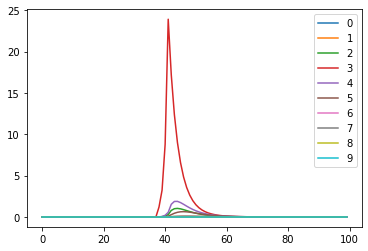

In [71]:
#@title Plotting true mass sample

for i in range(sites):
    plt.plot(range(length), sample[i], label = i)
plt.legend()

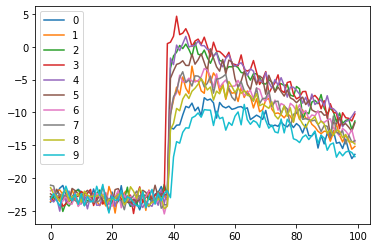

In [72]:
#@title Plotting true Y sample

CArray = convertConcentration(sites, length, sample, V, delta)
Y = convertY(CArray, trueTau)

for i in range(sites):
    plt.plot(range(length),Y[i, :], label = i)
plt.legend()

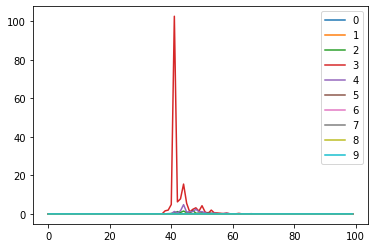

In [73]:
#@title Plotting true Y sample - Converted from log

for i in range(sites):
    plt.plot(range(length),np.e**Y[i, :], label = i)
plt.legend()

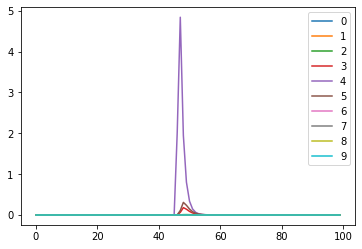

In [137]:
#@title Plotting Mass sample determined from parameters

massSample = getSample(sites, length, pmat, np.mean(alphaArray), np.mean(betaArray), phi[2], 
                       [int(np.mean(IArray[:, i])) for i in range(phi[2])], [int(np.mean(TArray[:, i])) for i in range(phi[2])], 
                       [int(np.mean(WArray[:, i])) for i in range(phi[2])], [np.mean(SArray[:, i]) for i in range(phi[2])])

for i in range(sites):
    plt.plot(range(length), massSample[i, :], label = i)
plt.legend()

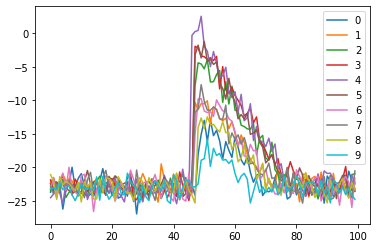

In [138]:
#@title Plotting Y sample determined from parameters

concSample = convertConcentration(sites, length, massSample, V, delta)
ySample = convertY(concSample, 1/np.sqrt(np.mean(tauArray)))

for i in range(sites):
    plt.plot(range(length), ySample[i, :], label = i)
plt.legend()

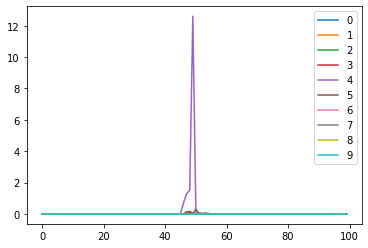

In [139]:
#@title Plotting Y sample determined from parameters - converted from log

for i in range(sites):
    plt.plot(range(length), np.e**ySample[i, :], label = i)
plt.legend()

## Alpha

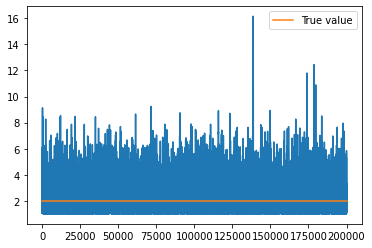

In [112]:
#@title Walk

plotWalk(alphaArray, trueAlpha)


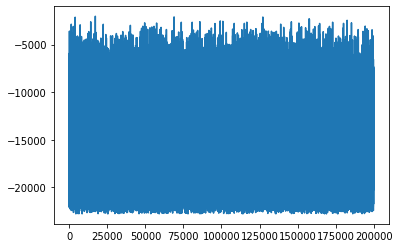

In [78]:
#@title Walk of likelihood

plt.plot(range(S - 1), alphaLikelihoodArray[:S - 1])

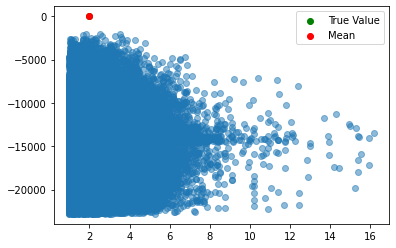

In [162]:
#@title Scatterplot of likelihood

plt.scatter(alphaArray[1:S], alphaLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueAlpha, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(alphaArray), 0, c = 'r', label = 'Mean')
plt.legend()

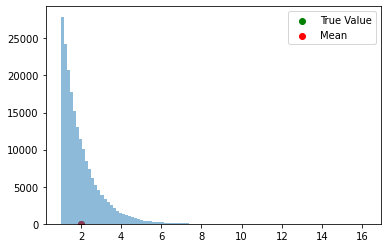

In [161]:
#@title Histogram

plt.hist(alphaArray[:S], bins = 100, alpha = 0.5)
plt.scatter(trueAlpha, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(alphaArray), 0, c = 'r', label = 'Mean')
plt.legend()

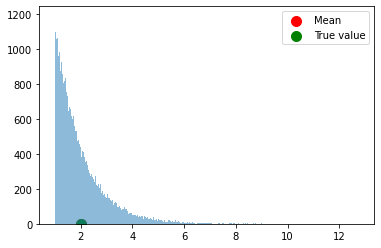

In [81]:
#@title PDF of prior

plotPDF(alphaPrior, np.mean(alphaArray), trueAlpha)

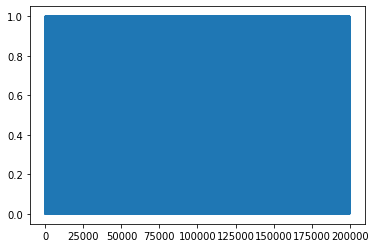

In [172]:
#@title Walk of accept ratio

plt.plot(range(S - 1), alphaRatioArray)

## Beta

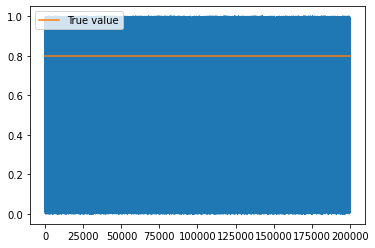

In [122]:
#@title Walk

plotWalk(betaArray, trueBeta)

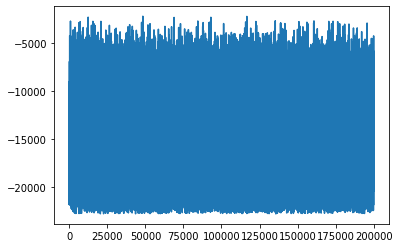

In [83]:
#@title Walk of likelihood

plt.plot(range(S - 1), betaLikelihoodArray[:S - 1])

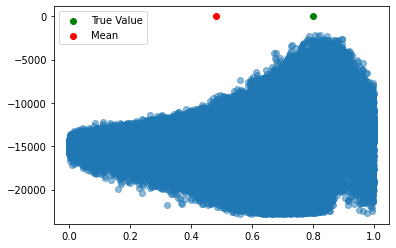

In [160]:
#@title Scatterplot of likelihood

plt.scatter(betaArray[1:S], betaLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueBeta, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(betaArray), 0, c = 'r', label = 'Mean')
plt.legend()

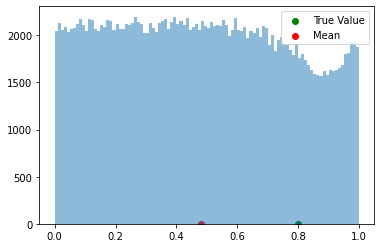

In [159]:
#@title Histogram

plt.hist(betaArray[:S], bins = 100, alpha = 0.5)
plt.scatter(trueBeta, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(betaArray), 0, c = 'r', label = 'Mean')
plt.legend()

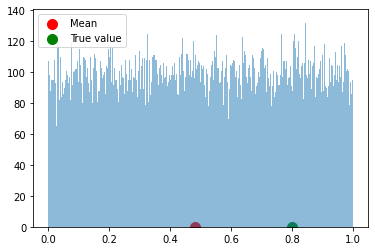

In [86]:
#@title PDF of prior

plotPDF(betaPrior, np.mean(betaArray[:S]), trueBeta)

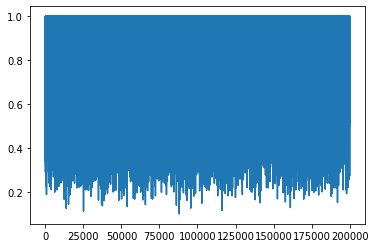

In [173]:
#@title Walk of accept ratio

plt.plot(range(S - 1), betaRatioArray)

## Tau

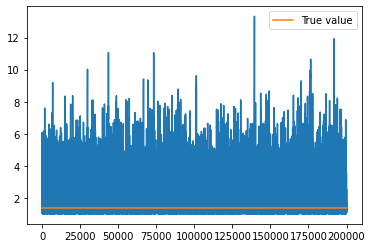

In [124]:
#@title Walk

plotWalk(tauArray, trueTau)

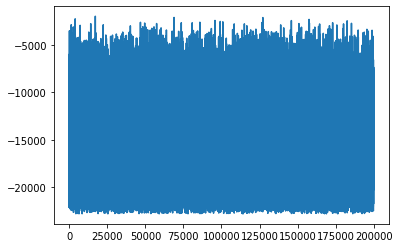

In [88]:
#@title Walk of likelihood

plt.plot(range(1,S), tauLikelihoodArray[:S-1])

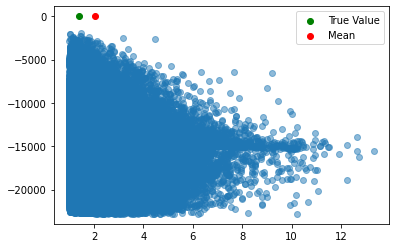

In [158]:
#@title Scatterplot of likelihood

plt.scatter(tauArray[1:S], tauLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueTau, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(tauArray), 0, c = 'r', label = 'Mean')
plt.legend()

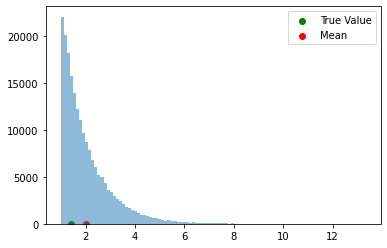

In [157]:
#@title Histogram

plt.hist(tauArray[:S], bins = 100, alpha = 0.5)
plt.scatter(trueTau, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(tauArray), 0, c = 'r', label = 'Mean')
plt.legend()

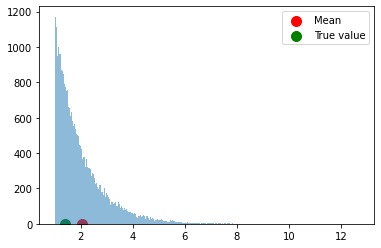

In [91]:
#@title PDF of prior

plotPDF(tauPrior, np.mean(tauArray[:S]), trueTau)

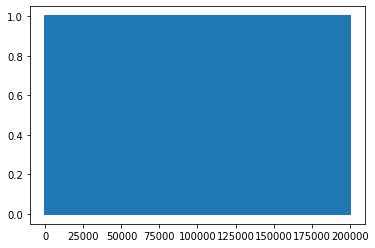

In [174]:
#@title Walk of accept ratio

plt.plot(range(S - 1), tauRatioArray)

## T

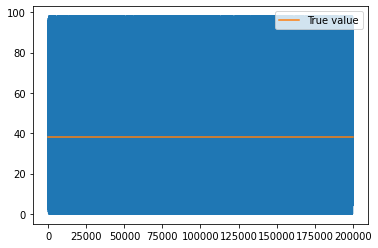

In [130]:
#@title Walk

plotWalk(TArray, trueT)

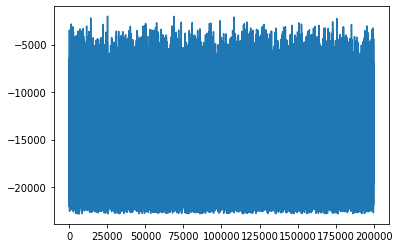

In [93]:
#@title Walk of likelihood

for i in range(phi[2]):
    plt.plot(range(1,S), TLikelihoodArray[:S-1, i])

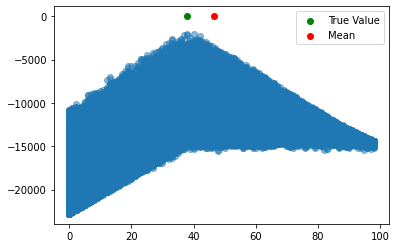

In [156]:
#@title Scatterplot of likelihood

plt.scatter(TArray[1:S], TLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueT, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(TArray), 0, c = 'r', label = 'Mean')
plt.legend()

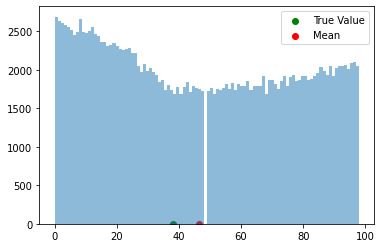

In [155]:
#@title Histogram

plt.hist(TArray[:, :S], bins = 100, alpha = 0.5)
plt.scatter(trueT, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(TArray), 0, c = 'r', label = 'Mean')
plt.legend()

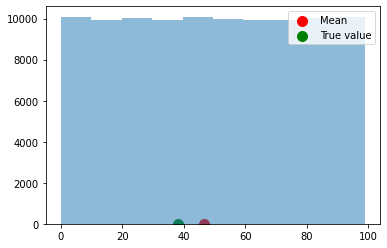

In [96]:
#@title PMF of Prior

plotPMF(TPrior, np.mean(TArray[:, :S]), trueT)

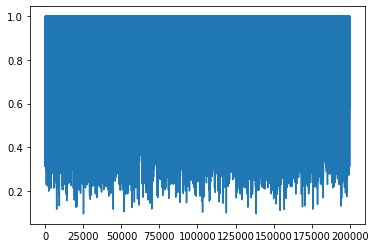

In [175]:
#@title Walk of accept ratio

plt.plot(range(S - 1), TRatioArray)

## W

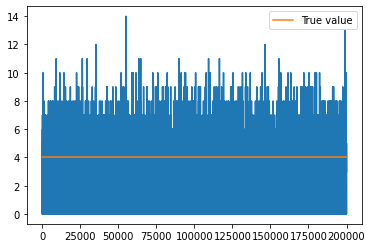

In [142]:
#@title Walk

plotWalk(WArray, trueW)

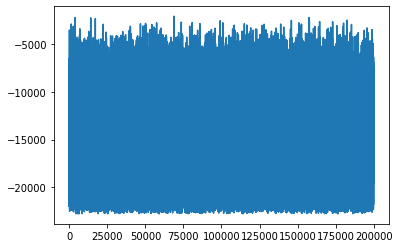

In [98]:
#@title Walk of likelihood

for i in range(phi[2]):
    plt.plot(range(S - 1), WLikelihoodArray[:S - 1, i])

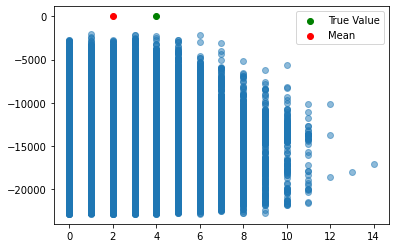

In [154]:
#@title Scatterplot of likelihood

plt.scatter(WArray[1:S], WLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueW, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(WArray), 0, c = 'r', label = 'Mean')
plt.legend()

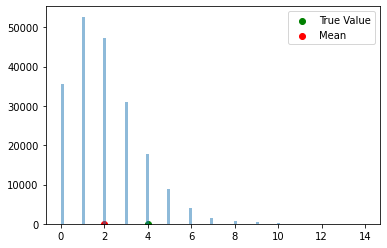

In [153]:
#@title Histogram

plt.hist(WArray[:, :S], bins = 100, alpha = 0.5)
plt.scatter(trueW, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(WArray), 0, c = 'r', label = 'Mean')
plt.legend()

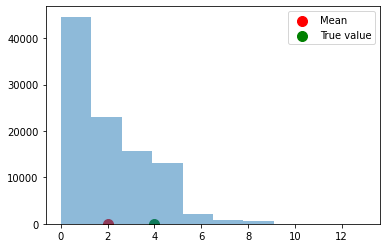

In [101]:
#@title PMF of Prior
plotPMF(WPrior, np.mean(WArray[:, :S]), trueW)

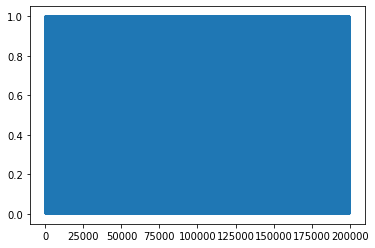

In [176]:
#@title Walk of accept ratio

plt.plot(range(S - 1), WRatioArray)

## S


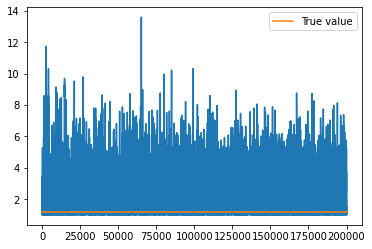

In [145]:
#@title Walk
plotWalk(SArray, trueS)

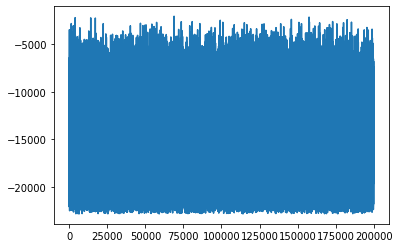

In [103]:
#@title Walk of likelihood

for i in range(phi[2]):
    plt.plot(range(S - 1), SLikelihoodArray[:S - 1, i])

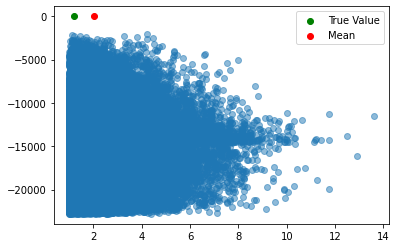

In [151]:
#@title Scatterplot of likelihood

plt.scatter(SArray[1:S], SLikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueS, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(SArray), 0, c = 'r', label = 'Mean')
plt.legend()

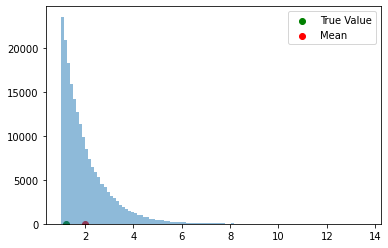

In [150]:
#@title Histogram
plt.hist(SArray[:, :S], bins = 100, alpha = 0.5)
plt.scatter(trueS, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(SArray), 0, c = 'r', label = 'Mean')
plt.legend()

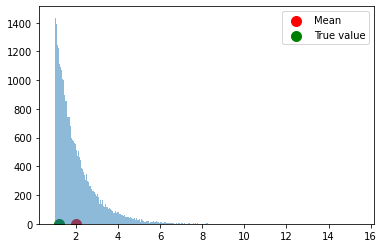

In [106]:
#@title PDF of Prior
plotPDF(SPrior, np.mean(SArray[:, :S]), trueS)

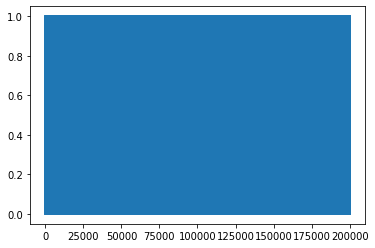

In [177]:
#@title Walk of accept ratio

plt.plot(range(S - 1), SRatioArray)

## I

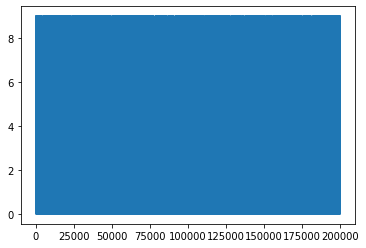

In [107]:
#@title Walk
plt.plot(range(S), IArray[:S])

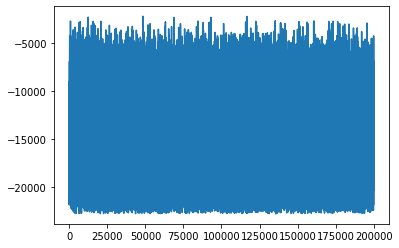

In [108]:
#@title Walk of likelihood

for i in range(phi[2]):
    plt.plot(range( S - 1), ILikelihoodArray[:S - 1, i])

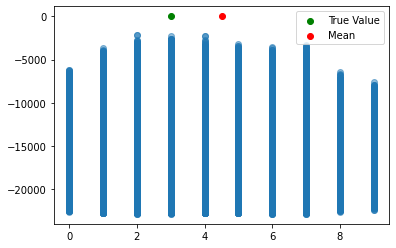

In [163]:
#@title Scatterplot of likelihood

plt.scatter(IArray[1:S], ILikelihoodArray[:S-1], alpha = 0.5)
plt.scatter(trueI, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(IArray), 0, c = 'r', label = 'Mean')
plt.legend()

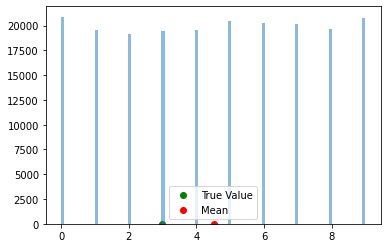

In [165]:
#@title Histogram
plt.hist(IArray[:S], bins = 100, alpha = 0.5)
plt.scatter(trueI, 0, c = 'g', label = 'True Value')
plt.scatter(np.mean(IArray), 0, c = 'r', label = 'Mean')
plt.legend()

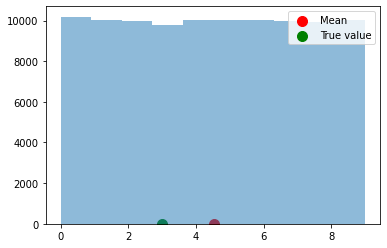

In [111]:
#@title PMF of Prior

plotPMF(IPrior, np.mean(IArray[:, :S]), trueI)

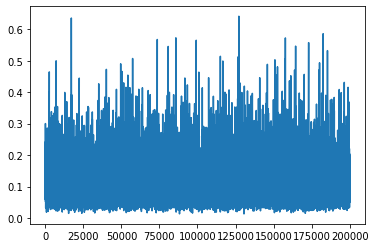

In [178]:
#@title Walk of accept ratio

plt.plot(range(S - 1), IRatioArray)